## Test dataset for C2B camera


+ `exp60`
    + 2019.06.05
    + camera pattern (all 0 -> all light to bucket1)
    + 4 projector patterns consisting of 4 spatial sinusoids
        + `Sinusoids-freq=04_bins=24_subframes=04/`
        + 96 pattern images -> 24/frame
    + 12 static scenes, (1000 frames/scene)
    + 60 ms exposure / subframe
    
+ `7patterns`
    + 2019.07.03
    + camera pattern (all 0)
    + 7 projector pattern consisting of 4 spatial sinusoids
        + `Sinusoids-freq=04_bins=12_subframes=07/`
        + 84 pattern images -> 12/frame
    + 10 static scenes, (980 frames/scene -> 140 frames to be averaged / subframe)
    + 60 ms exposure / subframe

In [2]:
import sys; sys.path.append('..')
import demosaicing as dm
import importlib; importlib.reload(dm)

<module 'demosaicing' from '../demosaicing/__init__.py'>

In [1]:
import glob
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
plt.rcParams['figure.figsize'] = (20,20)

In [3]:
# topdir = "../data/exp60"
# first_pattern_indices = [0,1,2,3]
# n_patterns = len(first_pattern_indices)
# n_frames_total = 1000
# n_frames_per_pattern = 250  # pick one myself
# n_scenes = 12

topdir = "../data/7patterns"
first_pattern_indices = [0,1,2,3,4,5,6]
n_patterns = len(first_pattern_indices)
n_frames_total = 980
n_frames_per_pattern = 140  # pick one myself
n_scenes = 10

assert(n_frames_per_pattern <= n_frames_total/n_patterns)
imgsize = (176, 288)

In [4]:
blacklvl = scipy.io.loadmat("../data/blacklevel_all1/blacklevel.mat");
blacklvl = blacklvl["blacklvl"]
# applies blacklevel for bucket1
def apply_blacklvl(im):
    return np.maximum(im.astype(np.float64)-np.squeeze(blacklvl[0,:,:]),np.zeros(np.shape(im)));

In [5]:
scenes = [x for x in os.listdir(topdir) if not x.startswith('.') and x != 'organized' and x != 'groundtruth']
scenes = scenes[:n_scenes]
scenes = {k: f'{os.path.join(topdir, k)}/bucket1*.png' for k in scenes}
scenes = {k: sorted(glob.glob(v)) for k,v in scenes.items()}
assert all([len(v) == n_frames_total for k,v in scenes.items()]), f'{[len(v) for k,v in scenes.items()]}'

stacks = {k: None for k in scenes.keys()}
for k,s in scenes.items():
    
    videos = np.zeros((len(s),*imgsize))
    for i,imgpath in enumerate(s):
        videos[i,:,:] = apply_blacklvl(cv.imread(imgpath, cv.IMREAD_GRAYSCALE))
    
    # since images corresponding to patterns [0,1,2,3] not in order at some point
    #     compute distance (frobenius norm) of images, and sort the frames by increasing distance metric
    frame_distance = np.zeros((len(first_pattern_indices),len(s)))
    for i in range(len(first_pattern_indices)):
        for j in range(len(s)):
            frame_distance[i,j] = np.linalg.norm(videos[i,:,:]-videos[j,:,:,],'fro')

    frame_distance = frame_distance.argsort(axis=1)
    frame_distance = {i: frame_distance[i,:] for i in first_pattern_indices}
    #     {pattern_id: [idx_to_closest_img, indx_to_second_closest_img, ...]}
    
    
    # now stack the first several for each pattern
    #     (4, 176, 288, n_frames_per_pattern)
    stack = np.zeros((n_patterns,*imgsize,n_frames_per_pattern), dtype=np.uint8)
    for pattern_id,indices_to_sorted in frame_distance.items():
        for j,imgidx in enumerate(indices_to_sorted[:n_frames_per_pattern]):
            stack[pattern_id,:,:,j] = videos[imgidx,:,:]
    
    print(f'stacking [ {n_frames_per_pattern} images / {n_patterns} patterns ] for scene={k}')
    stack = np.mean(stack/255., axis=3)
    stack = (stack*255).astype(np.uint8)
    stacks[k] = stack
    #     {k: (4, 176, 288)}

stacking [ 140 images / 7 patterns ] for scene=sponge
stacking [ 140 images / 7 patterns ] for scene=lamp
stacking [ 140 images / 7 patterns ] for scene=cup
stacking [ 140 images / 7 patterns ] for scene=chameleon
stacking [ 140 images / 7 patterns ] for scene=giraffe
stacking [ 140 images / 7 patterns ] for scene=head
stacking [ 140 images / 7 patterns ] for scene=minion
stacking [ 140 images / 7 patterns ] for scene=train
stacking [ 140 images / 7 patterns ] for scene=totem
stacking [ 140 images / 7 patterns ] for scene=cover


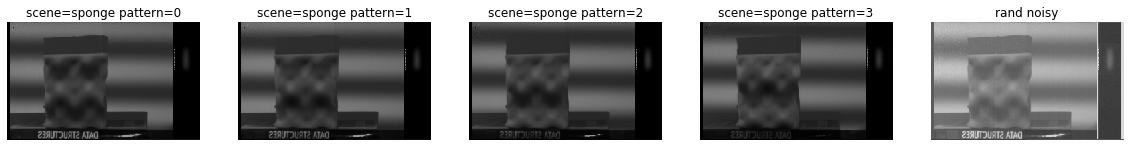

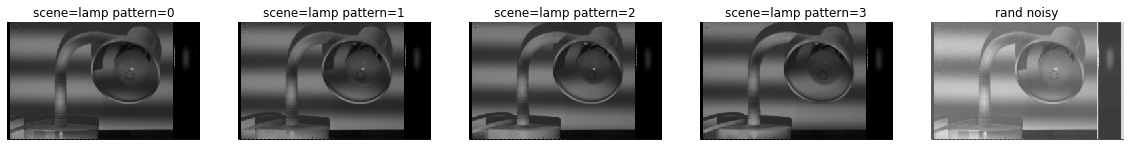

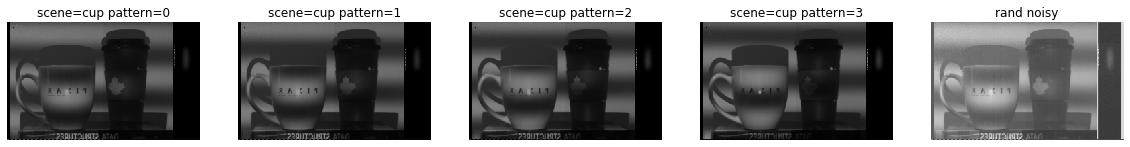

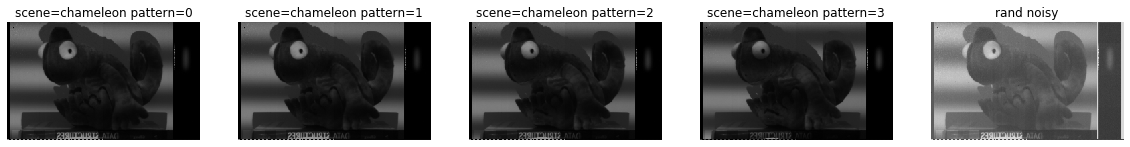

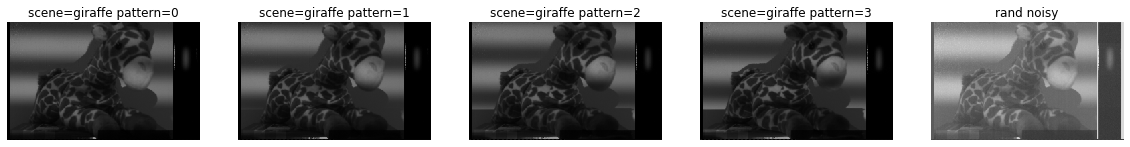

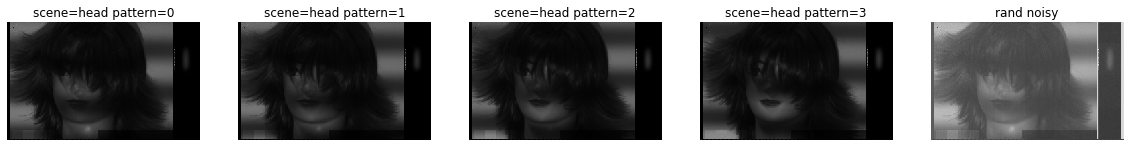

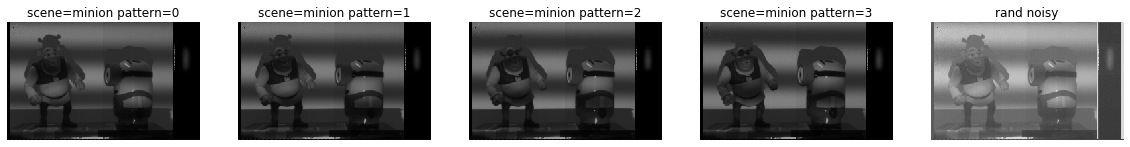

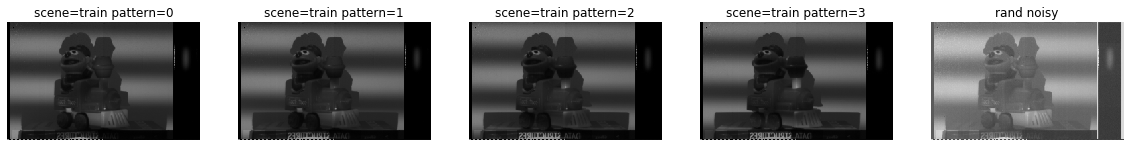

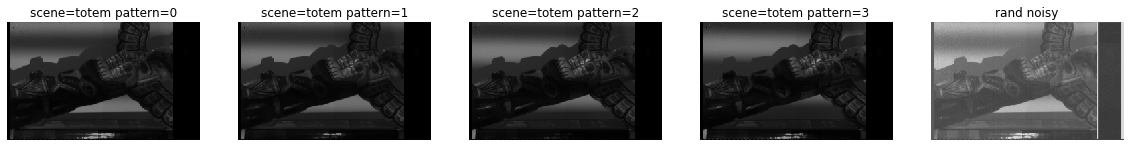

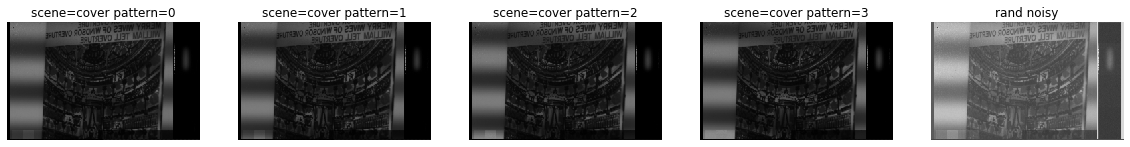

In [6]:
n_pattern_display = 4
for scene, stack in stacks.items():
    imgs = [stack[i,:,:] for i in range(n_pattern_display)] + \
            [cv.imread(scenes[scene][0], cv.IMREAD_GRAYSCALE)]

    desc = [f'scene={scene} pattern={i}' for i in range(n_pattern_display)] + ['rand noisy']
    dm.show_grayscales(imgs, desc, layouts=f'1{n_pattern_display+1}')
    

In [7]:
for scene,stack in stacks.items():

    outputdir = os.path.join(topdir,'organized')
    if not os.path.isdir(outputdir):
        os.makedirs(outputdir, exist_ok=True)
    print(f'outputing {n_patterns} stacked images for ({scene}) to [{outputdir}]')

    for i in range(n_patterns):
        cv.imwrite(os.path.join(outputdir, f'{scene}_{i}.png'), stack[i,:,:])

outputing 7 stacked images for (sponge) to [../data/7patterns/organized]
outputing 7 stacked images for (lamp) to [../data/7patterns/organized]
outputing 7 stacked images for (cup) to [../data/7patterns/organized]
outputing 7 stacked images for (chameleon) to [../data/7patterns/organized]
outputing 7 stacked images for (giraffe) to [../data/7patterns/organized]
outputing 7 stacked images for (head) to [../data/7patterns/organized]
outputing 7 stacked images for (minion) to [../data/7patterns/organized]
outputing 7 stacked images for (train) to [../data/7patterns/organized]
outputing 7 stacked images for (totem) to [../data/7patterns/organized]
outputing 7 stacked images for (cover) to [../data/7patterns/organized]
